In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
with openmc.StatePoint('statepoint.1000.h5') as sp:
    nx, ny = sp.get_tally(name="nufission").filters[0].mesh.dimension
    nufission = sp.get_tally(name="nufission").get_reshaped_data(expand_dims=False).squeeze()
    reshaped_nufission = sp.get_tally(name="nufission").get_reshaped_data(expand_dims=True).squeeze()
    f_ij = sp.get_tally(name="f_ij").get_reshaped_data(expand_dims=False).squeeze()
    fij_tally = sp.get_tally(name="f_ij")
    keff = sp.keff

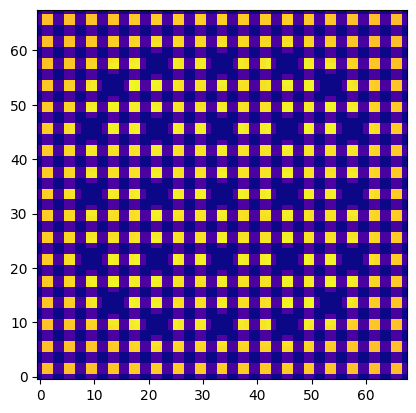

In [2]:
plt.imshow(reshaped_nufission, cmap='plasma', origin='lower')
plt.show()

In [3]:
print(f"MC computed keff:        {keff:.5f}")
print(f"keff from nufission sum: {np.sum(nufission):.5f}")
print(f"keff from f_ij sum:      {np.sum(f_ij):.5f}")

MC computed keff:        1.14821+/-0.00009
keff from nufission sum: 1.14826
keff from f_ij sum:      1.14826


Text(0.5, 1.0, '$f_{i,f}$ matrix with non-zero $\\nu\\Sigma_f$')

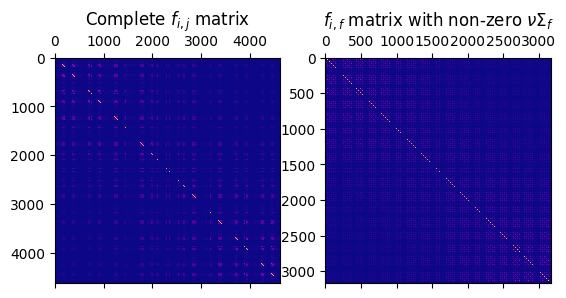

In [4]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(f_ij, cmap='plasma', origin='upper')
ax[0].set_title(r'Complete $f_{i,j}$ matrix')
ax[1].matshow(f_ij[nufission != 0, :][:, nufission != 0], cmap='plasma', origin='upper')
ax[1].set_title(r'$f_{i,f}$ matrix with non-zero $\nu\Sigma_f$')

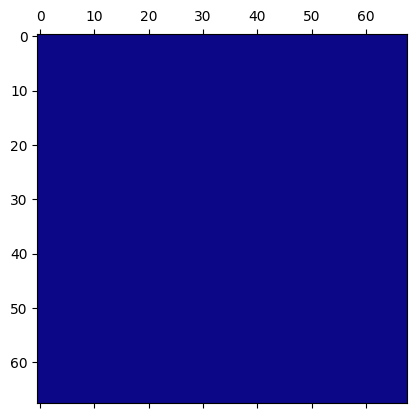

In [9]:
fig, ax = plt.subplots(1, 1)
fi = f_ij[:, 3]
ax.matshow(fi.reshape(nx, ny), cmap='plasma', origin='upper')

In [10]:
images = Path('images')
images.mkdir(exist_ok=True)
for j in range(0, nx * ny, 10):
    fig, ax = plt.subplots(1, 1)
    fi = f_ij[:, j]
    ax.matshow(fi.reshape(nx, ny), cmap='plasma', origin='upper')
    fig.savefig(images / f'f_{j}.png', dpi=300)
    plt.close()
    del fig, ax
to_remove = [f"f_{j}.png" for j in np.where(nufission == 0)[0]]
filenames = [f for f in images.glob('f_*.png') if f.name not in to_remove]
filenames = sorted(filenames, key=lambda x: int(x.stem.split('_')[1]))

pillows = [Image.open(f).convert("RGBA") for f in filenames]
pillows[0].save(
    'f_ij.gif',
    save_all=True,
    append_images=pillows[1:],
    duration=200,
    loop=0
)

Dominant eigenvalue: 1.14820e+00


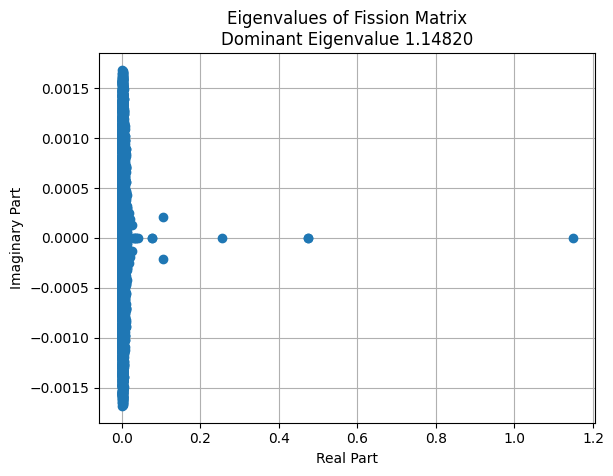

In [11]:
fixed_fij = f_ij[nufission != 0, :][:, nufission != 0]
p_j = nufission[nufission != 0] / keff.n
values, vectors = np.linalg.eig(fixed_fij / p_j)
values = np.sort(values)[::-1]
vectors = vectors[:, np.argsort(np.abs(values))][:, ::-1]
np.sort
print(f"Dominant eigenvalue: {np.max(np.abs(values)):.5e}")
fig, ax = plt.subplots(1, 1)
ax.plot(np.real(values), np.imag(values), 'o')
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_title(f'Eigenvalues of Fission Matrix\nDominant Eigenvalue {np.max(np.abs(values)):.5f}')
ax.grid()
plt.show()

In [12]:
p = Path("harmonics")
p.mkdir(exist_ok=True)
i = 0
for i in range(50):
    value = np.real(values[i])
    vector = np.real(vectors[:, i])
    to_restore = np.where(nufission == 0)[0]
    insert_idices = to_restore - np.arange(len(to_restore))
    restored = np.insert(vector, insert_idices, [0]).reshape(nx, ny)
    fig, ax = plt.subplots(1, 1)
    ax.imshow(restored, cmap='plasma', origin='upper', interpolation="bilinear")
    ax.set_title(f'Harmonic {i+1} with Eigenvalue {value:.5f}')
    fig.savefig(p / f'harmonic_{i+1}.png', dpi=300)
    plt.close()
    del fig, ax
# value = np.real(values[i])
# vector = np.real(vectors[:, i])
# to_restore = np.where(nufission == 0)[0]
# insert_idices = to_restore - np.arange(len(to_restore))
# restored = np.insert(vector, insert_idices, [0]).reshape(17, 17)
# fig, ax = plt.subplots(1, 1)
# ax.matshow(restored, cmap='plasma', origin='upper')
# fig.save()

(68, 68)
[[ 0.          0.00738399  0.00739417 ... -0.00024996 -0.0002374
   0.        ]
 [ 0.00742203  0.05590514  0.05581492 ... -0.00175275 -0.0018397
  -0.00025829]
 [ 0.00743708  0.05600552  0.05585137 ... -0.00165902 -0.00204787
  -0.00031904]
 ...
 [ 0.00028345  0.00196712  0.00181291 ... -0.05547517 -0.05566334
  -0.00736809]
 [ 0.00025465  0.00186091  0.00169752 ... -0.05583106 -0.05591685
  -0.00736051]
 [ 0.          0.00022564  0.00023643 ... -0.00743904 -0.00734491
   0.        ]]


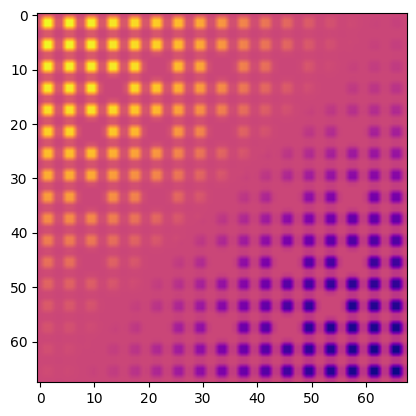

In [13]:
i = 1

from matplotlib import cm
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig, ax = plt.subplots(1, 1)
value = np.real(values[i])
vector = np.real(vectors[:, i])
to_restore = np.where(nufission == 0)[0]
insert_idices = to_restore - np.arange(len(to_restore))
restored = np.insert(vector, insert_idices, [0]).reshape(nx, ny)

# surf = ax.plot_surface(*restored.shape, restored, cmap=cm.coolwarm, linewidth=0, antialiased=False)
print(restored.shape)
print(restored)
# ax.plot_surface(*restored.shape, restored, antialiased=False, cmap=cm.coolwarm,)
ax.imshow(restored, cmap='plasma', origin='upper', interpolation="bilinear")